# Initial setup

In [1]:
import anndata
import scanpy as sc
import scycle as cc
import pandas as pd
import os
import sys

In [2]:
os.chdir('/home/clarice/Documents/SingleCell_PseudoTime/')

rbsc15 = anndata.read_h5ad('data/RBSC15.h5ad.gzip')

In [3]:
rbsc15.obs['total_counts'] = rbsc15.obs['TotalUMIs']

#-- Keep a copy for scycle
rbsc15_cc = rbsc15.copy()
rbsc15.layers['unnormalized'] = rbsc15.X

# scanpy

## Pre-processing

In [4]:
rbsc15

AnnData object with n_obs × n_vars = 2154 × 60662
    obs: 'TotalUMIs', 'total_counts'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced', 'unnormalized'

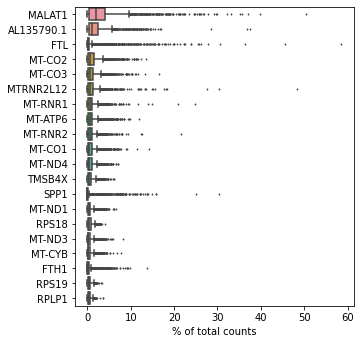

In [5]:
sc.pl.highest_expr_genes(rbsc15, n_top=20)

In [6]:
rbsc15.var['mt'] = rbsc15.var.index.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rbsc15, qc_vars = ['mt'], percent_top=None, log1p=False, inplace = True)

<AxesSubplot:xlabel='pct_counts_mt', ylabel='Count'>

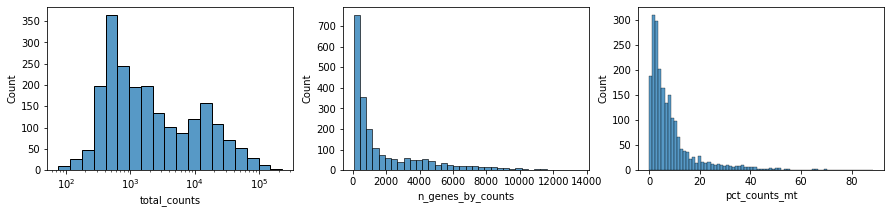

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols = 3, figsize=[15,3])
sns.histplot(data = rbsc15.obs, x = 'total_counts', log_scale = 10, ax=axes[0])
sns.histplot(data = rbsc15.obs, x = 'n_genes_by_counts', ax=axes[1])
sns.histplot(data = rbsc15.obs, x = 'pct_counts_mt', ax=axes[2])

In [8]:
kept_cells = (rbsc15.obs['n_genes_by_counts'] > 200) & (rbsc15.obs['pct_counts_mt'] < 20) & (rbsc15.obs['total_counts'] > 1000) & (rbsc15.obs['total_counts'] < 60000)
rbsc15 = rbsc15[kept_cells,:]
rbsc15

View of AnnData object with n_obs × n_vars = 1078 × 60662
    obs: 'TotalUMIs', 'total_counts', 'n_genes_by_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'matrix', 'spliced', 'unspliced', 'unnormalized'

In [9]:
sc.pp.normalize_total(rbsc15, target_sum=1e4)
sc.pp.log1p(rbsc15)

/home/clarice/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.


In [10]:
sc.pp.pca(rbsc15, svd_solver='arpack')
sc.pp.neighbors(rbsc15)

## Clustering

In [11]:
sc.tl.umap(rbsc15)
sc.tl.louvain(rbsc15)
sc.tl.rank_genes_groups(rbsc15, 'louvain', method='t-test')

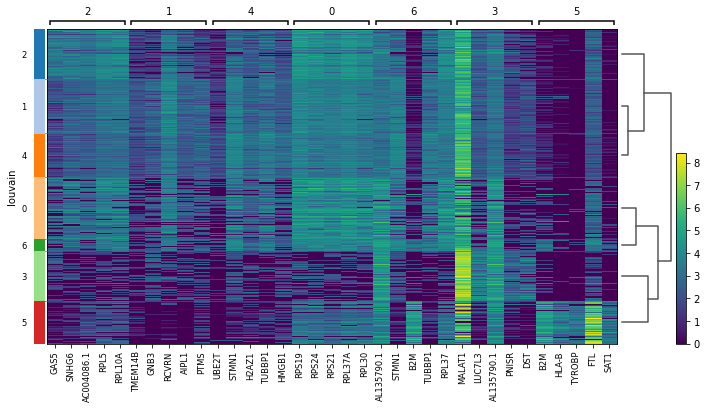

In [12]:
sc.pl.rank_genes_groups_heatmap(rbsc15, n_genes = 5)

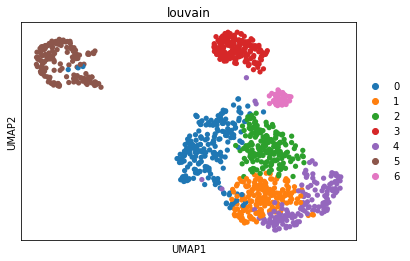

In [13]:
sc.pl.umap(rbsc15, color = 'louvain')

## Quick annotate clusters

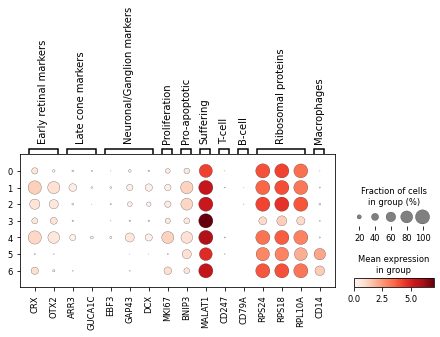

In [65]:
mkdict = {'Early retinal markers': ['CRX', 'OTX2'],
          'Late cone markers': ['ARR3', 'GUCA1C'],
          'Neuronal/Ganglion markers': ['EBF3', 'GAP43', 'DCX'],
          'Proliferation': 'MKI67',
          'Pro-apoptotic': 'BNIP3',
          'Suffering': ['MALAT1'],
          'T-cell': 'CD247', 
          'B-cell': 'CD79A', 
          'Ribosomal proteins': ['RPS24', 'RPS18', 'RPL10A'],
          'Macrophages': 'CD14'}

sc.pl.dotplot(rbsc15, mkdict, groupby = 'louvain')

In [15]:
cell_grouping = ['1', '2', '2', '1', 
                 '3', '4', '4']
annot_dict = dict(zip([str(i) for i in range(12)], cell_grouping))

In [16]:
clusters = list(rbsc15.obs['louvain'].values)
rbsc15.obs['cluster_annotation'] = [annot_dict[cl] for cl in clusters]

... storing 'cluster_annotation' as categorical


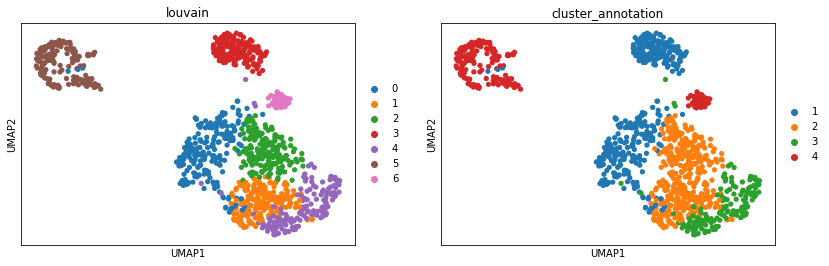

In [17]:
sc.pl.umap(rbsc15, color = ['louvain', 'cluster_annotation'], ncols = 2)

In [18]:
sc.tl.rank_genes_groups(rbsc15, 'cluster_annotation', method='wilcoxon')

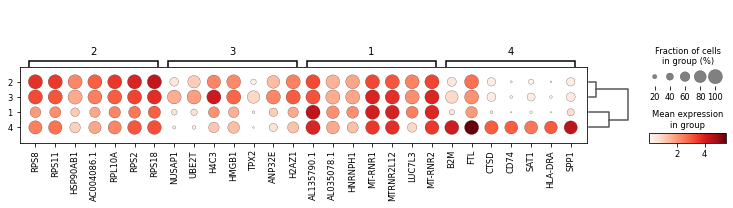

In [19]:
sc.pl.rank_genes_groups_dotplot(rbsc15, n_genes = 7)

In [20]:
named_groupings = {'1': 'Subtype2/Suffering', '2': 'Subtype2/Ribosomal', 
                   '3': 'Subtype2/Proliferating', '4': 'Macrophages'}
rbsc15.obs['cluster_annotation'].replace(named_groupings, inplace = True)

## CNV inference

In [21]:
rbsc15.var = rbsc15.var.rename(columns={'Chromosome': 'chromosome', 'ChromosomeStart': 'start', 'ChromosomeEnd': 'end'})

In [22]:
import infercnvpy as cnv

cnv.tl.infercnv(
    rbsc15,
    reference_key="cluster_annotation",
    reference_cat = 'Macrophages',
    window_size=250,
)

... storing 'cluster_annotation' as categorical


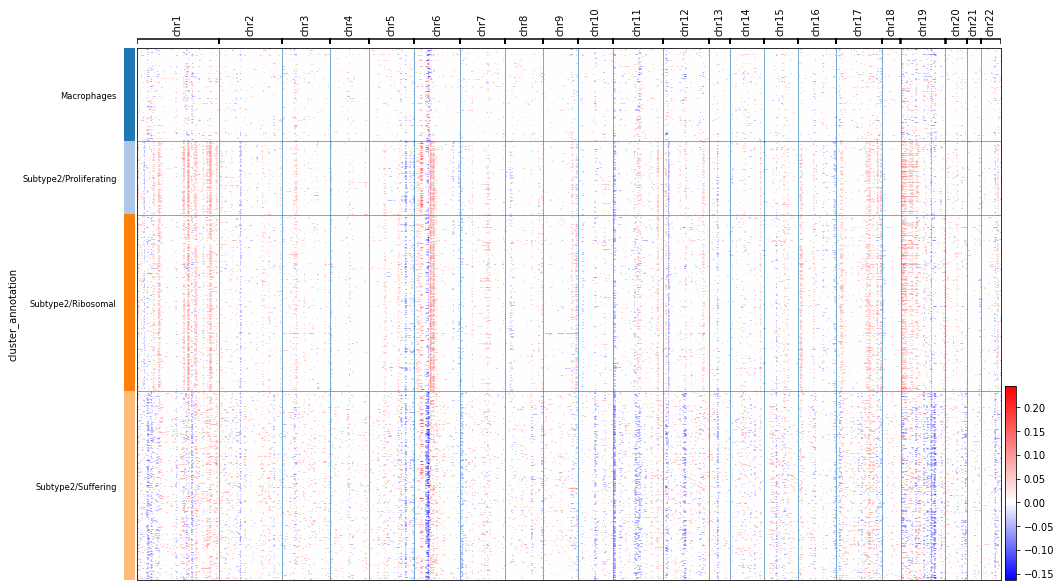

In [23]:
cnv.pl.chromosome_heatmap(rbsc15, groupby="cluster_annotation")

## Score cell cycle using scanpy

In [24]:
sc.tl.score_genes_cell_cycle(rbsc15, s_genes = cc.data.g1s_markers, g2m_genes=cc.data.g2m_markers)

... storing 'cluster_annotation' as categorical
... storing 'phase' as categorical


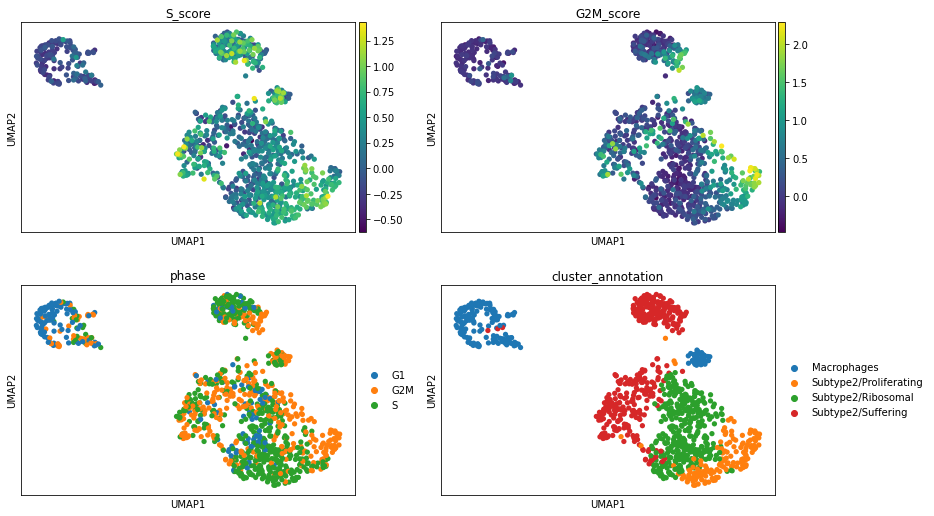

In [25]:
sc.pl.umap(rbsc15, color = ['S_score', 'G2M_score', 'phase', 'cluster_annotation'], ncols = 2)

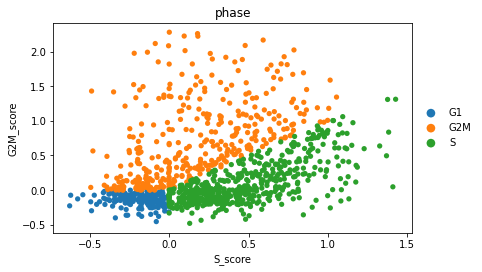

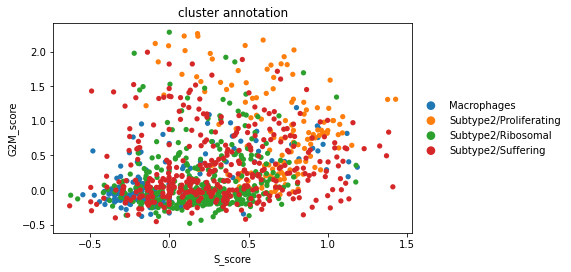

In [26]:
sc.pl.scatter(rbsc15, x = 'S_score', y = 'G2M_score', color = 'phase')
sc.pl.scatter(rbsc15, x = 'S_score', y = 'G2M_score', color = 'cluster_annotation')

# scycle

In [28]:
rbsc15_cc = rbsc15_cc[rbsc15.obs.index,:]

In [29]:
rbsc15_cc.obs['cluster_annotation'] = rbsc15.obs['cluster_annotation']

Trying to set attribute `.obs` of view, copying.


In [32]:
sbty2 = rbsc15_cc[rbsc15_cc.obs['cluster_annotation'].isin(['Subtype2/Ribosomal', 'Subtype2/Proliferating'])]

In [34]:
cc.pp.prep_pooling(sbty2)
cc.tl.dimensionality_reduction(sbty2)

Preparing embedding...
Embedding for pooling...
Pooling 506 cells...
Scoring cell cycle...
-- Dimensionality reduction using ICA...
-- Done
--- Selected components:
G1-S: 4 (score=5.312072)
G2-M: 0 (score=8.662797)


In [35]:
sbty2.obs['total_counts'] = sbty2.obs['total_counts'].astype('float64')

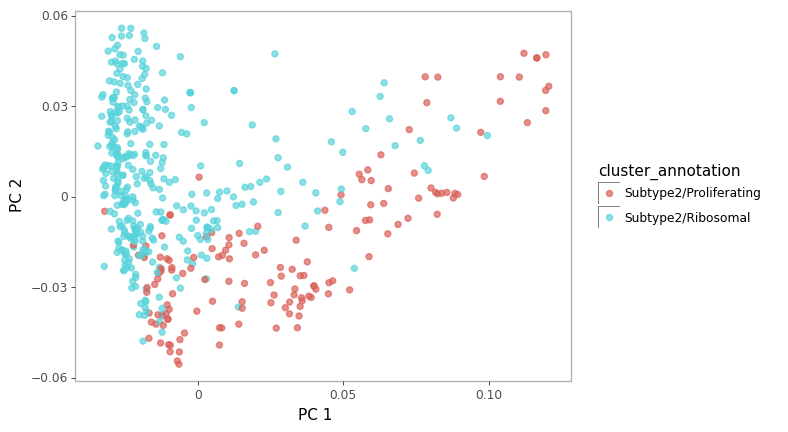

<ggplot: (8793778437527)>

In [38]:
cc.pl.cell_cycle_pca(sbty2, size = 2, col_var = 'cluster_annotation')

In [39]:
prolif = sbty2[sbty2.obs['cluster_annotation'] == 'Subtype2/Proliferating']

In [40]:
cc.tl.dimensionality_reduction(prolif)

-- Dimensionality reduction using ICA...
-- Done
--- Selected components:
G1-S: 2 (score=4.236697)
G2-M: 0 (score=7.009284)


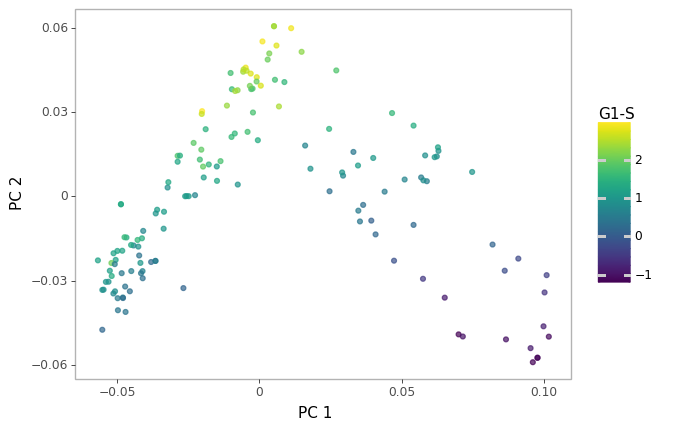

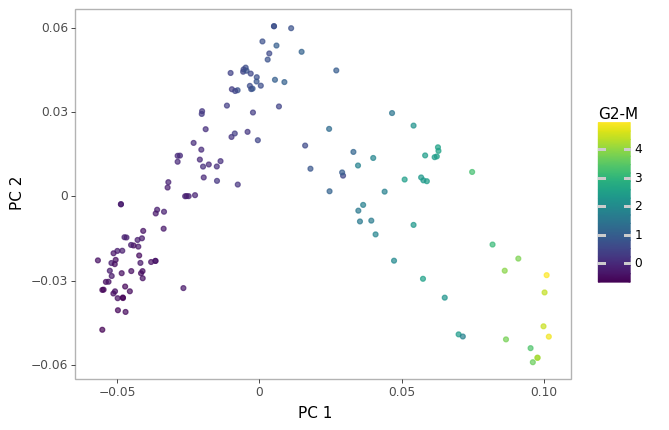

(<ggplot: (8793796042409)>, <ggplot: (8793914594292)>)

In [41]:
(cc.pl.cell_cycle_pca(prolif, col_var = 'G1-S'), cc.pl.cell_cycle_pca(prolif, col_var = 'G2-M'))

In [42]:
cc.tl.integration(sbty2, prolif)

-- Automatically detecting cell-cycle components...
-- Integrating datasets...
> Selecting common genes...
> 10000 genes selected.
> Slicing matrices...
> Performing optimal transport based integration using WOTi...
Woti > Successfully initialized.
(Woti) ot based -- max_iter: 10000000 -- entropy regularized, hreg: 0.001000 -- unweighted
WOTi > Computing optimal transport plan...
WOTi > Projecting source dataset...
-- Done


In [53]:
cc.tl.trajectory(sbty2, n_nodes = 15)

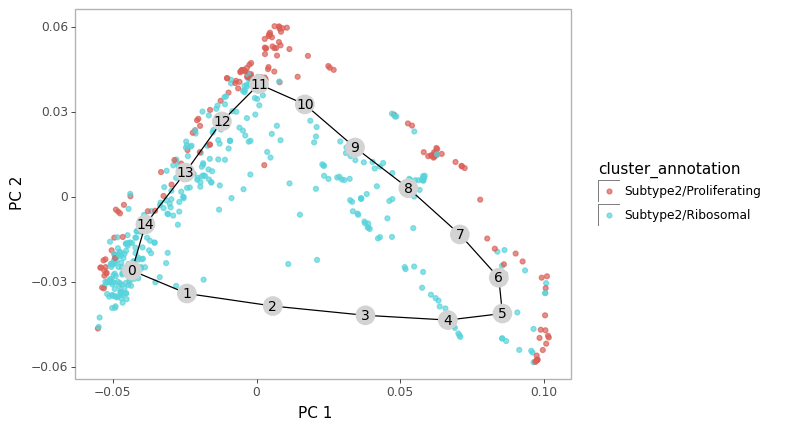

<ggplot: (8793913308639)>

In [54]:
cc.pl.cell_cycle_pca(sbty2, trajectory = True, col_var = 'cluster_annotation')

In [55]:
cc.tl.cell_division(sbty2, remap=False)
cc.tl.remap_nodes(sbty2, celldiv_edge = (2,3), cycle_direction = -1)

Suggested moment of cell division: [6 7]
Direction of cell cycle: -1
Remapping edges using (2, 3) ...


Calculating pseudotimes for each cell...
-- Suggested cell cycle division:
G1:  0   - 0.4
S:  0.4 - 0.65
G2: 0.65 - 0.8666666666666667
M:  0.8666666666666667 -   1


/home/clarice/.local/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_vline : Removed 1 rows containing missing values.


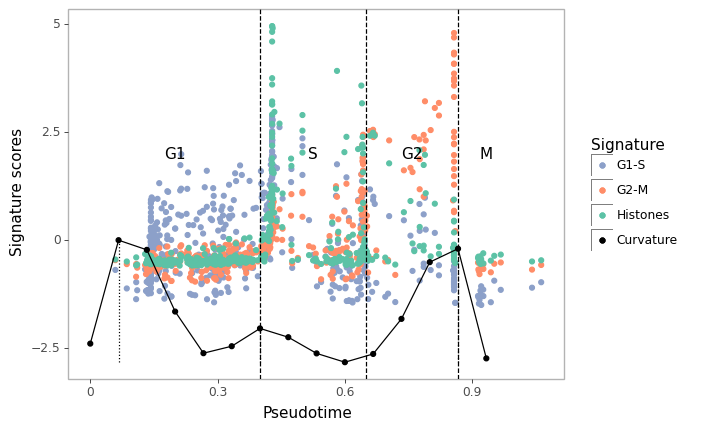

<ggplot: (8793913262466)>

In [57]:
cc.tl.pseudotime(sbty2)
cc.tl.cell_cycle_phase(sbty2)
cc.pl.cell_cycle_scores(sbty2)

In [61]:
rbsc15.obs = rbsc15.obs.join(sbty2.obs.loc[:,['G1-S', 'G2-M', 'pseudotime', 'cell_cycle_phase']])
rbsc15.obs['cell_cycle_phase'] = rbsc15.obs['cell_cycle_phase'].cat.add_categories('NaN').fillna('NaN')

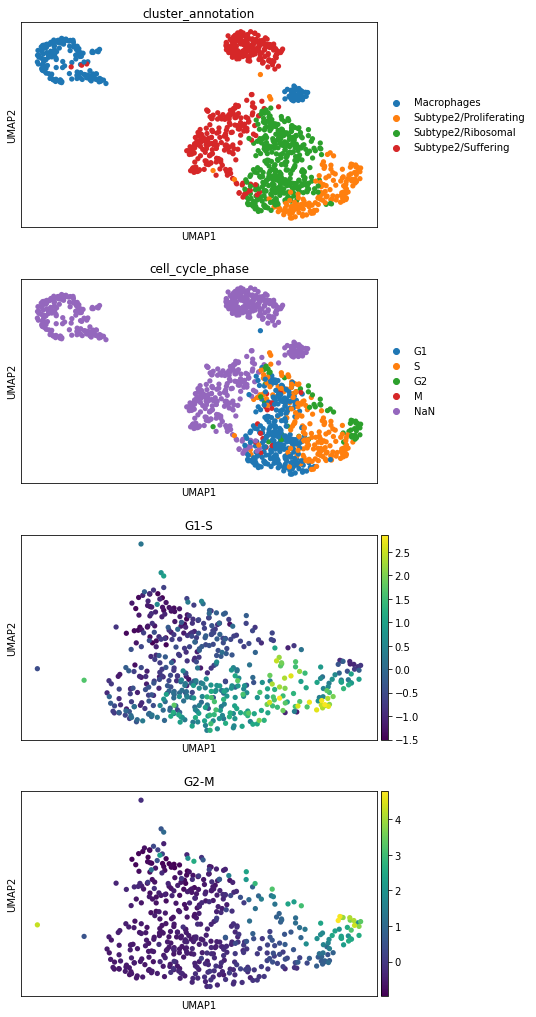

In [63]:
sc.pl.umap(rbsc15, color=['cluster_annotation', 'cell_cycle_phase', 'G1-S', 'G2-M'], ncols = 1)